# =============================================
# Projeto Integrador 3B — Sistema de Recomendação de Filmes
# Notebook de Exploração, Grafos e Recomendação
# =============================================

# 🎬 Sistema de Recomendação de Filmes
Este notebook implementa um sistema de recomendação de filmes baseado em **filtragem colaborativa usando grafos**.

Fluxo:
1. Carregar dataset MovieLens
2. Explorar dados
3. Criar grafo bipartido (usuário ↔ filme)
4. Projetar grafo sobre filmes (filme ↔ filme)
5. Gerar recomendações para usuários
6. Visualizar resultados


In [3]:
import pandas as pd
from pathlib import Path

# Caminho para os CSVs
data_dir = Path("../data/")

ratings_path = data_dir / "ratings.csv"
movies_path = data_dir / "movies.csv"

# Carregar datasets
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Verificar os dados
print("Ratings:", ratings.shape)
ratings.head()

print("\nMovies:", movies.shape)
movies.head()

Ratings: (100836, 4)

Movies: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Verificar colunas
print(ratings.columns)
print(movies.columns)

# Estatísticas básicas dos ratings
ratings.describe()

# Quantos usuários e filmes únicos existem?
print("Número de usuários:", ratings['userId'].nunique())
print("Número de filmes:", ratings['movieId'].nunique())

# Top 10 usuários que mais avaliaram
ratings.groupby('userId')['rating'].count().sort_values(ascending=False).head(10)

# Top 10 filmes mais avaliados
ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)

# Top 10 filmes com maior média (mínimo 10 avaliações para evitar outliers)
movie_stats = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['mean_rating', 'num_ratings']
top_movies = movie_stats[movie_stats['num_ratings'] >= 10].sort_values('mean_rating', ascending=False).head(10)
top_movies = top_movies.merge(movies, left_index=True, right_on='movieId')
top_movies[['title', 'mean_rating', 'num_ratings']]

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Index(['movieId', 'title', 'genres'], dtype='object')
Número de usuários: 610
Número de filmes: 9724


,title,mean_rating,num_ratings
796,Secrets & Lies (1996),4.590909,11
2582,Guess Who's Coming to Dinner (1967),4.545455,11
883,Paths of Glory (1957),4.541667,12
841,"Streetcar Named Desire, A (1951)",4.475000,20
1762,"Celebration, The (Festen) (1998)",4.458333,12
918,Ran (1985),4.433333,15
277,"Shawshank Redemption, The (1994)",4.429022,317
731,His Girl Friday (1940),4.392857,14
1407,All Quiet on the Western Front (1930),4.350000,10
2593,"Hustler, The (1961)",4.333333,18


In [5]:
import networkx as nx

# Criar grafo bipartido
B = nx.Graph()

# Adicionar nós de usuários e filmes
B.add_nodes_from(ratings['userId'].unique(), bipartite='users', type='user')
B.add_nodes_from(movies['movieId'].unique(), bipartite='movies', type='movie')

# Adicionar arestas (usuário -> filme) com peso = rating
edges = [(row.userId, row.movieId, {'weight': row.rating}) for row in ratings.itertuples()]
B.add_edges_from(edges)

print("Grafo bipartido criado!")
print("Número de nós:", B.number_of_nodes())
print("Número de arestas:", B.number_of_edges())

Grafo bipartido criado!
Número de nós: 9829
Número de arestas: 100403


In [6]:
from networkx.algorithms import bipartite

# Lista de nós de filmes
movie_nodes = [n for n,d in B.nodes(data=True) if d['type']=='movie']

# Projeção ponderada: filme-filme
G_movie = bipartite.weighted_projected_graph(B, movie_nodes)

print("Grafo projetado (filmes) criado!")
print("Número de nós:", G_movie.number_of_nodes())
print("Número de arestas:", G_movie.number_of_edges())

# Ver peso de algumas conexões
list(G_movie.edges(data=True))[:10]

Grafo projetado (filmes) criado!
Número de nós: 9829
Número de arestas: 13944872


[(np.int64(1), 2, {'weight': 73}),
 (np.int64(1), 3, {'weight': 42}),
 (np.int64(1), 4, {'weight': 58}),
 (np.int64(1), 5, {'weight': 56}),
 (np.int64(1), 6, {'weight': 150}),
 (np.int64(1), 7, {'weight': 61}),
 (np.int64(1), 8, {'weight': 37}),
 (np.int64(1), 9, {'weight': 17}),
 (np.int64(1), 10, {'weight': 80}),
 (np.int64(1), 11, {'weight': 65})]

In [7]:
def recommend_for_user(user_id, B, G_movie, k=10, min_rating=4):
    """
    Recomenda filmes para um usuário com base na projeção de filmes.
    
    user_id : int
        ID do usuário
    B : nx.Graph
        Grafo bipartido (usuários-filmes)
    G_movie : nx.Graph
        Grafo projetado (filme-filme), com peso de similaridade
    k : int
        Número de recomendações a retornar
    min_rating : int
        Considera apenas filmes avaliados com rating >= min_rating
    """
    # Filmes que o usuário avaliou acima do mínimo
    user_movies = [(nbr, B[user_id][nbr]['weight']) 
                   for nbr in B.neighbors(user_id) 
                   if B[user_id][nbr]['weight'] >= min_rating]
    
    if not user_movies:
        return []  # Usuário sem avaliações altas
    
    scores = {}
    
    # Para cada filme avaliado pelo usuário
    for movie, rating in user_movies:
        if movie not in G_movie:
            continue
        # Vizinho no grafo projetado (filme-filme)
        for neighbor in G_movie.neighbors(movie):
            # Ignora filmes que o usuário já avaliou
            if neighbor in [m for m,_ in user_movies]:
                continue
            # Soma ponderada pelo peso da aresta e rating do usuário
            w = G_movie[movie][neighbor].get('weight', 1.0)
            scores[neighbor] = scores.get(neighbor, 0) + w * rating
    
    # Ordenar scores decrescente e pegar top-K
    recommendations = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]
    
    return recommendations

In [8]:
# Exemplo: recomendar para o usuário 1
user_id = 1
recommendations = recommend_for_user(user_id, B, G_movie, k=5)

# Mostrar os IDs e pesos
print("Recomendações (movieId, score):")
print(recommendations)

# Mostrar os títulos dos filmes recomendados
recommended_ids = [movie_id for movie_id, _ in recommendations]
recommended_titles = movies[movies['movieId'].isin(recommended_ids)][['movieId','title']]
print(recommended_titles)

Recomendações (movieId, score):
[(599, 155741.5), (480, 143284.5), (608, 132825.5), (68, 122347.5), (318, 115092.5)]
     movieId                               title
60        68  French Twist (Gazon maudit) (1995)
277      318    Shawshank Redemption, The (1994)
418      480                Jurassic Park (1993)
515      599              Wild Bunch, The (1969)
520      608                        Fargo (1996)


In [9]:
import plotly.graph_objects as go
import pandas as pd
import networkx as nx

def plot_user_recommendations(user_id, B, G_movie, movies, recommendations, top_n_rated=5):
    """
    Visualiza os filmes melhor avaliados pelo usuário e os filmes recomendados.
    
    user_id : int
        ID do usuário
    B : nx.Graph
        Grafo bipartido usuário-filme
    G_movie : nx.Graph
        Grafo projetado filme-filme
    movies : pd.DataFrame
        DataFrame com colunas ['movieId', 'title']
    recommendations : list
        Lista de tuplas (movieId, score)
    top_n_rated : int
        Quantos filmes bem avaliados do usuário exibir
    """
    
    # Filmes avaliados pelo usuário
    user_movies = [(nbr, B[user_id][nbr]['weight']) for nbr in B.neighbors(user_id)]
    rated_sorted = sorted(user_movies, key=lambda x: x[1], reverse=True)[:top_n_rated]
    rated_ids = [mid for mid, _ in rated_sorted]
    
    recommended_ids = [mid for mid, _ in recommendations]
    
    # Subgrafo: inclui os filmes avaliados e recomendados
    nodes_to_include = set(rated_ids + recommended_ids)
    subG = G_movie.subgraph(nodes_to_include)
    
    # Layout de rede
    pos = nx.spring_layout(subG, seed=42)
    
    # Nós — separados por tipo
    rated_x = [pos[n][0] for n in rated_ids if n in pos]
    rated_y = [pos[n][1] for n in rated_ids if n in pos]
    rec_x = [pos[n][0] for n in recommended_ids if n in pos]
    rec_y = [pos[n][1] for n in recommended_ids if n in pos]
    
    # Arestas
    edge_x = []
    edge_y = []
    for edge in subG.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
    
    # Cria gráfico interativo
    fig = go.Figure()
    
    # Arestas (conexões entre filmes)
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        mode='lines',
        line=dict(width=1, color='lightgray'),
        hoverinfo='none',
        name='Similaridade'
    ))
    
    # Filmes avaliados
    rated_titles = movies[movies['movieId'].isin(rated_ids)].set_index('movieId')['title']
    fig.add_trace(go.Scatter(
        x=rated_x, y=rated_y,
        mode='markers+text',
        marker=dict(size=14, color='blue'),
        text=[rated_titles.get(mid, f"Movie {mid}") for mid in rated_ids],
        textposition="top center",
        name='Filmes Avaliados (Alta Nota)'
    ))
    
    # Filmes recomendados
    rec_titles = movies[movies['movieId'].isin(recommended_ids)].set_index('movieId')['title']
    fig.add_trace(go.Scatter(
        x=rec_x, y=rec_y,
        mode='markers+text',
        marker=dict(size=14, color='orange'),
        text=[rec_titles.get(mid, f"Movie {mid}") for mid in recommended_ids],
        textposition="top center",
        name='Filmes Recomendados'
    ))
    
    # Ajustes visuais
    fig.update_layout(
        title=f"🎬 Recomendações para o Usuário {user_id}",
        showlegend=True,
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white',
        hovermode='closest'
    )
    
    fig.show()

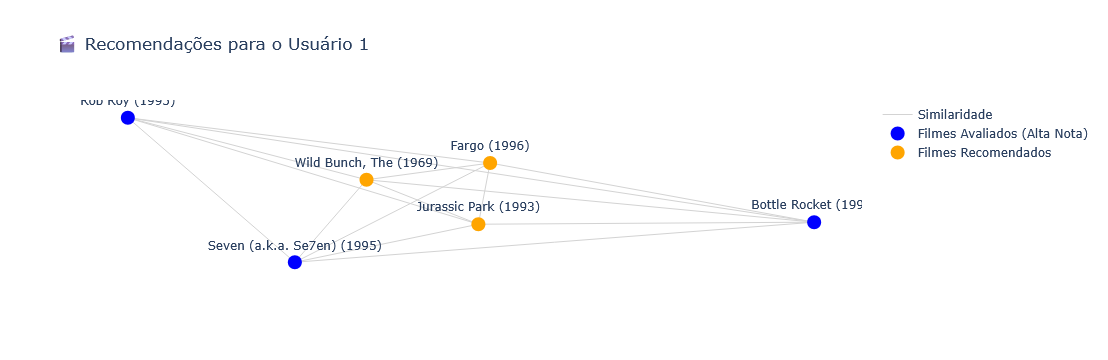

In [13]:
# Exemplo
user_id = 1
recommendations = recommend_for_user(user_id, B, G_movie, k=3)

plot_user_recommendations(user_id, B, G_movie, movies, recommendations, top_n_rated=3)

In [11]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import networkx as nx

def plot_user_recommendations_radial(user_id, B, G_movie, movies, recommendations, top_n_rated=5):
    """
    Visualização radial dos filmes melhor avaliados pelo usuário e dos recomendados.
    - Filmes avaliados (alta nota): no centro
    - Filmes recomendados: ao redor
    - Linhas: conexões de similaridade entre eles
    """
    
    # Filmes avaliados pelo usuário
    user_movies = [(nbr, B[user_id][nbr]['weight']) for nbr in B.neighbors(user_id)]
    rated_sorted = sorted(user_movies, key=lambda x: x[1], reverse=True)[:top_n_rated]
    rated_ids = [mid for mid, _ in rated_sorted]
    recommended_ids = [mid for mid, _ in recommendations]
    
    # Garantir que existam títulos
    rated_titles = movies[movies['movieId'].isin(rated_ids)].set_index('movieId')['title']
    rec_titles = movies[movies['movieId'].isin(recommended_ids)].set_index('movieId')['title']
    
    # Posições radiais
    n_rated = len(rated_ids)
    n_recommended = len(recommended_ids)
    
    # Filmes avaliados no centro (em cruz ou círculo pequeno)
    rated_positions = {
        mid: (0.2 * np.cos(2*np.pi*i/n_rated),
              0.2 * np.sin(2*np.pi*i/n_rated))
        for i, mid in enumerate(rated_ids)
    }
    
    # Filmes recomendados em círculo externo
    rec_positions = {
        mid: (1.0 * np.cos(2*np.pi*i/n_recommended),
              1.0 * np.sin(2*np.pi*i/n_recommended))
        for i, mid in enumerate(recommended_ids)
    }
    
    # Combinar posições
    positions = {**rated_positions, **rec_positions}
    
    # Linhas entre filmes avaliados e recomendados
    edge_x, edge_y = [], []
    for rated in rated_ids:
        if rated not in G_movie:
            continue
        for rec in recommended_ids:
            if rec in G_movie[rated]:
                x0, y0 = positions[rated]
                x1, y1 = positions[rec]
                edge_x += [x0, x1, None]
                edge_y += [y0, y1, None]
    
    # Cria gráfico Plotly
    fig = go.Figure()
    
    # Arestas
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        mode='lines',
        line=dict(width=1, color='lightgray'),
        hoverinfo='none',
        name='Similaridade'
    ))
    
    # Filmes avaliados (centro)
    fig.add_trace(go.Scatter(
        x=[positions[mid][0] for mid in rated_ids],
        y=[positions[mid][1] for mid in rated_ids],
        mode='markers+text',
        marker=dict(size=16, color='blue'),
        text=[rated_titles.get(mid, f"Movie {mid}") for mid in rated_ids],
        textposition="top center",
        name='Filmes Avaliados'
    ))
    
    # Filmes recomendados (periferia)
    fig.add_trace(go.Scatter(
        x=[positions[mid][0] for mid in recommended_ids],
        y=[positions[mid][1] for mid in recommended_ids],
        mode='markers+text',
        marker=dict(size=14, color='orange'),
        text=[rec_titles.get(mid, f"Movie {mid}") for mid in recommended_ids],
        textposition="top center",
        name='Filmes Recomendados'
    ))
    
    # Ajustes visuais
    fig.update_layout(
        title=f"🎯 Visualização Radial — Recomendações para o Usuário {user_id}",
        showlegend=True,
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white',
        hovermode='closest',
        width=800,
        height=800
    )
    
    fig.show()


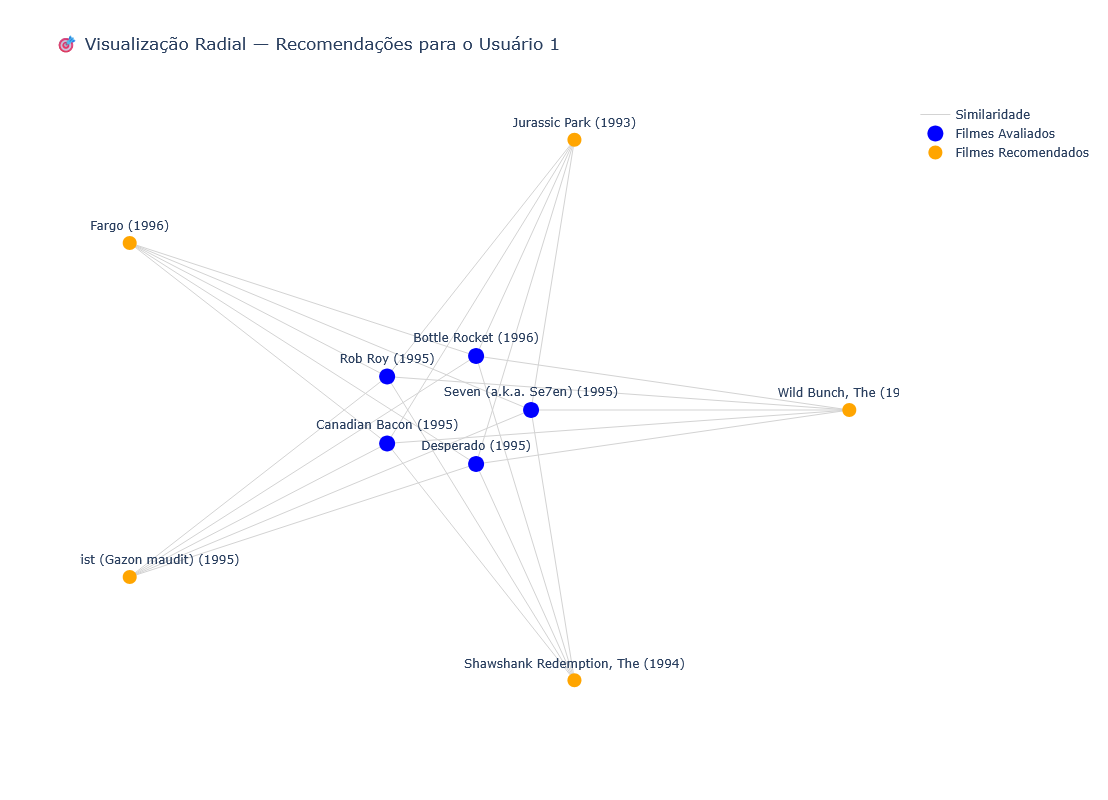

In [12]:
# Exemplo de uso
user_id = 1
recommendations = recommend_for_user(user_id, B, G_movie, k=5)

plot_user_recommendations_radial(user_id, B, G_movie, movies, recommendations, top_n_rated=5)